In [1]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    create_intersection_dataloader,
)
from tree_detection_framework.detection.detector import (
    GeometricTreeTopDetector,
    GeometricTreeCrownDetector,
)
from tree_detection_framework.postprocessing.postprocessing import (
    remove_edge_detections,
)

/home/exouser/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (None)/charset_normalizer (3.4.1) doesn't match a supported version!
  warnings.warn(
/home/exouser/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
RASTER_FOLDER_PATH = "/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif"
CHIP_SIZE = 512
CHIP_STRIDE = 400
RESOLUTION = 0.2

In [3]:
# Stage 1: Create a dataloader for the raster data and detect the tree-tops
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
)

treetop_detector = GeometricTreeTopDetector(a=0.0045, confidence_feature="height")

treetop_detections = treetop_detector.predict(dataloader)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400
Performing prediction on batches: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


In [4]:
# Display outputs from a tile
treetop_detections.get_region_detections(0).get_data_frame()

,height,score,geometry
0,17.092934,17.092934,POINT (752266.89 4317061.699)
1,31.942705,31.942705,POINT (752320.29 4317061.699)
2,29.120504,29.120504,POINT (752292.49 4317060.499)
3,47.325111,47.325111,POINT (752235.89 4317058.299)
4,6.176466,6.176466,POINT (752302.29 4317057.299)
...,...,...,...
69,25.123983,25.123983,POINT (752258.09 4316974.499)
70,20.961731,20.961731,POINT (752282.89 4316974.499)
71,27.227255,27.227255,POINT (752228.89 4316971.699)
72,10.089941,10.089941,POINT (752235.89 4316963.299)


In [5]:
# treetop unique_IDs get generated when merged
merged = treetop_detections.merge()
merged.get_data_frame()

,height,score,geometry,region_ID,unique_ID
0,17.092934,17.092934,POINT (752266.89 4317061.699),0,00000
1,31.942705,31.942705,POINT (752320.29 4317061.699),0,00001
2,29.120504,29.120504,POINT (752292.49 4317060.499),0,00002
3,47.325111,47.325111,POINT (752235.89 4317058.299),0,00003
4,6.176466,6.176466,POINT (752302.29 4317057.299),0,00004
...,...,...,...,...,...
826,24.793400,24.793400,POINT (752472.29 4317207.299),15,00826
827,12.540923,12.540923,POINT (752479.09 4317204.299),15,00827
828,7.012718,7.012718,POINT (752466.69 4317203.299),15,00828
829,19.218321,19.218321,POINT (752464.09 4317199.499),15,00829


In [6]:
# Remove the tree tops that were generated in the edges of tiles. This is an alternative to NMS.
treetop_detections = remove_edge_detections(
    treetop_detections,
    suppression_distance=(CHIP_SIZE - CHIP_STRIDE) * RESOLUTION / 2,
)

In [7]:
# Stage 2: Combine raster and vector data (from the tree-top detector) to create a new dataloader
raster_vector_dataloader = create_intersection_dataloader(
    raster_data=RASTER_FOLDER_PATH,
    vector_data=treetop_detections,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
)

INFO:root:Stride = 400
INFO:root:Units = Units.PIXELS
INFO:pyogrio._io:Created 436 records
INFO:root:RegionDetectionsSet temporarily saved to: /tmp/tmp3d39e8c4.geojson


Converting CustomRasterDataset CRS from EPSG:26910 to EPSG:26910


In [14]:
treecrown_detector = GeometricTreeCrownDetector()

treecrown_detections = treecrown_detector.predict(raster_vector_dataloader)

Performing prediction on batches: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]


In [9]:
# Display outputs from the tree crown detector. Note: treetop UIDs get maintained.
treecrown_detections.get_data_frame(merge=True)

,score,height,treetop_unique_ID,geometry,region_ID,unique_ID
0,5967.972887,43.287262,00000,"POLYGON ((752260.379 4317045.199, 752259.511 4...",0,00000
1,376.500000,16.555063,00001,"POLYGON ((752286.89 4317048.499, 752286.89 431...",0,00001
2,677.092593,23.613422,00002,"POLYGON ((752283.49 4317038.299, 752283.69 431...",0,00002
3,501.345701,21.239635,00003,"POLYGON ((752282.995 4317036.394, 752282.89 43...",0,00003
4,2260.548646,27.959467,00004,"POLYGON ((752259.535 4317026.741, 752260.781 4...",0,00004
...,...,...,...,...,...,...
641,747.000000,28.890852,00431,"POLYGON ((752407.09 4317217.499, 752406.89 431...",11,00641
642,874.422030,13.274141,00432,"POLYGON ((752452.471 4317221.825, 752451.69 43...",11,00642
643,384.941558,10.006784,00433,"POLYGON ((752472.672 4317235.699, 752473.29 43...",11,00643
644,635.934018,14.572286,00434,"POLYGON ((752474.018 4317225.208, 752477.09 43...",11,00644


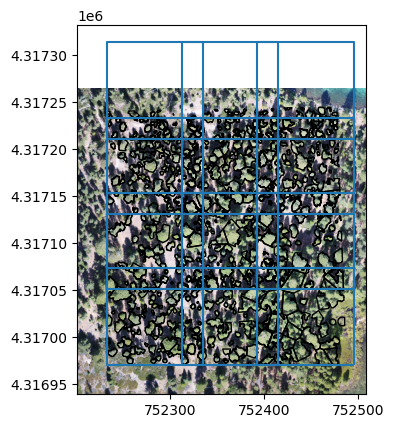

<Axes: >

In [10]:
treecrown_detections.plot(
    raster_file="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho/ortho.tif"
)